**The goal** of this research is to identify if there are any attributes we are seeing in high-performing SPACs _(e.g. sponsor, underwriter, whether warrants trading, target industry etc.)._ 

We are pretty limited in the data we can access for free, so this will primarily be conducted leveraging [SPAC Track](https://spactrack.net/) for now.

`run_appendix` will run appendix cells if set to True. `load_10_13_20_csv` will load the pre-processed dataframe to save time

### Data Ingestion and Feature Engineering

In [1]:
run_appendix = False

load_10_13_20_csv = True

In [2]:
#Import libs
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display, Image
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta, datetime
from pandasql import sqldf
import os
import urllib.request
from urllib.request import urlopen
import requests
import re
import json
from pandas.io.json import json_normalize
import lxml.html as lh
import random
import scipy
import math
import joypy

#Activate SQL syntax in notebook from pandasql package
pysqldf = lambda q: sqldf(q, globals())

In [3]:
if load_10_13_20_csv:
    #Ingest data
    file_path =\
        '/Users/adrianlechter/Lechter Ventures/Supplementary Files/df_spactrack_10_13_20.csv'
    df_spactrack = pd.read_csv(file_path)
    df_spactrack.drop(columns=['Unnamed: 0'], inplace=True)

    #Preview data
    pd.set_option('display.max_columns', 500)
    display(df_spactrack.head())
    display(df_spactrack.info())
    pd.set_option('display.max_columns', 20)
    
else:

    #Ingest data
    file_path =\
        '/Users/adrianlechter/Lechter Ventures/Supplementary Files/SPAC Track Data Dump 10-12-20.csv'
    df_spactrack = pd.read_csv(file_path)

    #Preview data
    display(df_spactrack.head())
    display(df_spactrack.info())

,ticker,company_name,merged_company_name,spac_name,completion_date,post-completion_events,total_return_since_SPAC_IPO_spactrack,annualized_return_spactrack,current_price_spactrack,percent_change_prev_spactrack,market_cap_spactrack,is_warrants_trading,SPAC_IPO_date,SPAC_IPO_size,SPAC_initial_target_industry,notable_leadership_/_sponsor,SPAC_underwriter(s),Status,open_after_completion_date,close_1yr_after_completion_date,1yr_after_completion_date,is_goldman_underwriter,is_earlybird_underwriter,is_deutsche_underwriter,is_cantor_underwriter,is_chardan_underwriter,is_I-Bankers_underwriter,is_citigroup_underwriter
0,DKNG,DraftKings Inc,NaN,Diamond Eagle Acquisition Corp (DEAC),2020-04-23,NaN,412.30%,NaN,$51.23,4.94%,"$18,268,431,693",False,2019-05-10,$400.00,"Online Casino, Sports Betting","Jeff Sagansky, Harry Sloan (Former CEO of MGM)","Deutsche Bank, Goldman Sachs",Trading,20.494000,NaN,NaN,True,False,True,False,False,False,False
1,IMVT,Immunovant Inc.,Immunovant Sciences Ltd.,Health Sciences Acquisition (IMVT),2019-12-19,NaN,312.30%,NaN,$41.23,-2.26%,"$3,591,696,996",False,2019-05-09,$100.00,"Biopharma, MedTech, Healthcare",RTW Investments,"Chardan, UBS",Trading,15.530000,NaN,NaN,False,False,False,False,True,False,False
2,CCC,Clarivate Analytics Plc,NaN,Churchill Capital I (CCC),2019-05-13,NaN,227.00%,159.95%,$32.70,-0.30%,"$12,682,396,230",True,2018-09-06,$690.00,NaN,Michael Klein (Former Co-CEO of Citi Markets a...,"Citi, B. Riley FBR",Trading,13.450000,22.84,2020-05-12,False,False,False,False,False,False,True
3,PRPL,"Purple Innovation, Inc.",NaN,Global Partner Acquisition Corp. (GPAC),2018-02-02,NaN,194.80%,72.33%,$29.48,1.80%,NaN,True,2015-07-29,$155.25,NaN,NaN,Deutsche Bank,Trading,9.700000,5.71,2019-02-04,False,False,True,False,False,False,False
4,HYLN,Hyliion,NaN,Tortoise Acquisition Corp (SHLL),2020-10-01,NaN,190.00%,NaN,$29.00,-2.46%,"$4,463,152,200",True,2019-02-27,$233.00,Energy,Vincent T. Cubbage (Tortoise Capital Advisors),"Barclays, Goldman Sachs",Trading,39.990002,NaN,NaN,True,False,False,False,False,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 28 columns):
ticker                                   72 non-null object
company_name                             72 non-null object
merged_company_name                      26 non-null object
spac_name                                72 non-null object
completion_date                          72 non-null object
post-completion_events                   7 non-null object
total_return_since_SPAC_IPO_spactrack    68 non-null object
annualized_return_spactrack              29 non-null object
current_price_spactrack                  66 non-null object
percent_change_prev_spactrack            66 non-null object
market_cap_spactrack                     63 non-null object
is_warrants_trading                      72 non-null bool
SPAC_IPO_date                            72 non-null object
SPAC_IPO_size                            72 non-null object
SPAC_initial_target_industry             50 non-null object


None

**Open Questions/Notes for Data Pre-processing**
- Fetching your own price/return data from FMP given it might be tough to trust SPAC Track.
    - Testing by manually checking prices. Decided against it since current prices look close enough.
- Make `is_warrants_trading` a boolean column
- Include a couple boolean for sponsors/underwriters and other columns you plan on cutting on

In [4]:
if load_10_13_20_csv:
    pass

else:

    #Opening price on the day after completion date announcement
    #Tons of notes below on these edge cases. Many of these traded under a different ticker before acquisition date
    edge_case_opening_price_dict =\
        {'SPCE':12.34,'VVNT':11.05,'BWMX':8,'DMTK':5.48,'ATCX':10.48,
        'KLDI':9.9,'PECK':18.60,'IGIC':7.04,'ALTG':10.5,'KLR':11.35,'OSW':12,
        'SJ':9.89,'METX':18,'GSMG':4,'AGLY':0,'HUNTF':0,'XYN':0,'CCN':0}
    #Issue with KLDI: couldn't find ticker price anywhere near completion date (date used is from 2020-01-28).
    #this may happen because there is very little liquidity

    #Another issue with PECK. This may have been specific to Spac Track where they're incorrectly listing
    #completion date (noted in feedback email to Spac Track)

    #Another issue with METX. This may have been specific to Spac Track where they're incorrectly listing
    #completion date (noted in feedback email to Spac Track)

    #Need to remove AGLY. First off it trades super wide with no volume. 
    #Also business wire notes:
        #"As previously announced, FSAC and Agiliti have waived the closing condition under the merger agreement that 
        #would have required Agiliti’s common stock and warrants to be listed on the NASDAQ stock exchange. 
        #The common stock and warrants of Agiliti will not be listed at closing of the transaction."

    #HUNTF, XYN and CCN need to be removed. First 2 were delisted, the second was acquired

In [5]:
if load_10_13_20_csv:
    pass
        
else:
    #Closing prices one year after completion date. One note noted below
    edge_case_closing_price_dict =\
        {'SPCE':np.nan,'VVNT':np.nan,'BWMX':np.nan,'DMTK':11.77,'ATCX':np.nan,'KLDI':np.nan,
        'PECK':3.3,'IGIC':np.nan,'ALTG':np.nan,'KLR':np.nan,'OSW':2.79,
        'SJ':np.nan,'METX':np.nan,'GSMG':np.nan,'AGLY':np.nan,'HUNTF':np.nan,'XYN':np.nan,'CCN':np.nan}

    #ALGY has a price but we're going to filter it out from consideration given opening price commentary
    #Final 3 tickers are not having prices per notes in the opening price dictionary

    #Add all the edge case tickers to a list
    edge_case_tickers_list = []
    for key in edge_case_closing_price_dict.keys():
        edge_case_tickers_list.append(key)

In [6]:
if load_10_13_20_csv:
    pass

else:
    #Track which SPACs didn't get open price after completion date added
    missing_open_after_completion_date_list = []

    #make is_warrants_trading a boolean
    df_spactrack['is_warrants_trading'] =\
        df_spactrack['is_warrants_trading'].apply(lambda x: True if x == 'Warrants Trading' else False )

    #Make completion_date datetime
    df_spactrack['completion_date'] = pd.to_datetime(df_spactrack['completion_date'])

    #Add empty morning after completion date column (to be populated below)
    df_spactrack['open_after_completion_date'] = ""
    df_spactrack['close_1yr_after_completion_date'] = ""

    #Get one year date from completion date, mark np.nan if not
    df_spactrack['1yr_after_completion_date'] =\
        df_spactrack['completion_date'].\
        apply(lambda x: x + timedelta(days = 365) if x + timedelta(days = 365) <= datetime.today() and (x + timedelta(days = 365)).weekday() < 5 
              else (x + timedelta(days = 367) if x + timedelta(days = 367) <= datetime.today() and (x + timedelta(days = 365)).weekday() == 5 
              else (x + timedelta(days = 366) if x + timedelta(days = 366) <= datetime.today() and (x + timedelta(days = 365)).weekday() == 6 else np.nan)))  

    #Get price on open the morning after completion date announcement and close 1 yr later
    for i in range(len(df_spactrack)):

        #Get completion date, ticker, and day after completion date
        completion_date_as_date = df_spactrack.at[i,'completion_date']
        ticker = df_spactrack.at[i,'ticker']
        day_after_completion_date = completion_date_as_date + timedelta(days = 1)
        yr_later_completion_date_as_date = df_spactrack.at[i,'1yr_after_completion_date']

        #Convert day after completion date to weekday if its on weekend
        if day_after_completion_date.weekday() == 5:
            day_after_completion_date += timedelta(days = 2)

        elif day_after_completion_date.weekday() == 6:
            day_after_completion_date += timedelta(days = 1)

        #Set day after completion date to string for API call
        day_after_completion_date = day_after_completion_date.strftime('%Y-%m-%d')

        if ticker in edge_case_tickers_list:

            #Insert edge case opening and closing prices into dataframe
            df_spactrack.at[i,'open_after_completion_date'] = edge_case_opening_price_dict[ticker]
            df_spactrack.at[i,'close_1yr_after_completion_date'] = edge_case_closing_price_dict[ticker]
            continue

        else:

            #First we'll fetch the opening prices date after completion date
            url =\
            'https://financialmodelingprep.com/api/v3/historical-price-full/{}?from={}&to={}&apikey=fea2346da5cfa1d8bc886e40496d718b'.\
            format(ticker,day_after_completion_date,day_after_completion_date)

            try:
                url_1 = urllib.request.urlopen(url)
                data = json.loads(url_1.read().decode())['historical']


            except:
                if not url_1:
                    try:
                        time.sleep(2) #wait for another try
                        url_1_attempt_2 = urllib.request.urlopen(url)
                        data = json.loads(url_1_attempt_2.read().decode())[0]

                    except:
                        display('you got to this part of script')



            df_historicals_opening = pd.DataFrame(data) #opening price dataframe


            #Insert opening price post completion date into dataframe
            df_spactrack.at[i,'open_after_completion_date'] = df_historicals_opening['open'][0]

            #Get closing price data if SPAC has been trading for 1yr+
            if not pd.isnull(yr_later_completion_date_as_date):

                #Set day after completion date to string for API call
                yr_later_completion_date_as_date = yr_later_completion_date_as_date.strftime('%Y-%m-%d')

                try:
                    url2 =\
                    'https://financialmodelingprep.com/api/v3/historical-price-full/{}?from={}&to={}&apikey=fea2346da5cfa1d8bc886e40496d718b'.\
                    format(ticker,yr_later_completion_date_as_date,yr_later_completion_date_as_date)
                    url_2 = urllib.request.urlopen(url2)
                    data2 = json.loads(url_2.read().decode())['historical']

                except:
                    if not url_2:
                        try:
                            time.sleep(2) #wait for another try
                            url_2_attempt_2 = urllib.request.urlopen(url2)
                            data2 = json.loads(url_2_attempt_2.read().decode())[0]

                        except:
                            display('you got to this part of script')
                    else:
                        missing_open_after_completion_date_list.append(ticker)
                        display('End of script error')

                df_historicals_closing = pd.DataFrame(data2) #historical time series

                #Insert closing prices [if available] 1yr after completion date into dataframe
                df_spactrack.at[i,'close_1yr_after_completion_date'] = df_historicals_closing['close'][0]

            else:
                pass

    #Label all major underwriters with booleans for reporting
    underwriter_dict =\
        {'goldman':[r'Goldman Sachs', r'Goldman, Sachs'], 'earlybird':r'EarlyBirdCapital', 
         'deutsche':r'Deutsche Bank','cantor':[r'Cantor Fitzgerald', r'Cantor'], 'chardan':r'Chardan', 
         'I-Bankers':r'I-Bankers','citigroup':[r'Citi', r'Citigroup']}

    #function used for reporting labeling
    def matcher(x):
        for i in value:
            if i.lower() in x.lower():
                return True
        else:
            return False

    for key,value in underwriter_dict.items():
        if len(value) != 2:
            df_spactrack['is_{}_underwriter'.format(key)] =\
                df_spactrack['SPAC_underwriter(s)'].str.contains(value, na=True)

        else:
            df_spactrack['is_{}_underwriter'.format(key)] =\
                df_spactrack['SPAC_underwriter(s)'].apply(matcher)

    pd.set_option('display.max_columns', 500)
    display(df_spactrack.head())
    display(df_spactrack.info())
    pd.set_option('display.max_columns', 20)

### Exploratory Analysis

Before we dive into the questions I do want to confirm that the values I'm seeing here actually make sense. I'm going to spot-check two different values to start.

In [7]:
#Spot checking - commenting out random numbers so I dont recalculate
random_number_1 = random.randint(0,71)
random_number_2 = random.randint(0,71)
pd.set_option('display.max_rows', 500)
display(pd.DataFrame(df_spactrack.iloc[random_number_1]))
display(pd.DataFrame(df_spactrack.iloc[random_number_2]))
pd.set_option('display.max_rows', 11)

,69
ticker,CVON
company_name,ConvergeOne Holdings Inc
merged_company_name,NaN
spac_name,Forum Merger Corporation (FMCI)
completion_date,2018-02-23
post-completion_events,Acquired by CVC Fund VII (Nov 2018 - $1.8B)
total_return_since_SPAC_IPO_spactrack,NaN
annualized_return_spactrack,NaN
current_price_spactrack,NaN
percent_change_prev_spactrack,NaN


,65
ticker,HUNTF
company_name,Hunter Maritime Acquisition Corp
merged_company_name,NCF Wealth Holdings Limited
spac_name,Hunter Maritime Acquisition Corp (HUNT)
completion_date,2019-03-21
post-completion_events,Delisted (April 2019)
total_return_since_SPAC_IPO_spactrack,-95.00%
annualized_return_spactrack,-60.73%
current_price_spactrack,$0.50
percent_change_prev_spactrack,0.00%


Spot check looks good. Let's outline key questions we'd like to answer with our data.

- Looking at YoY returns (while bucketing <1yr SPACs into single group), how has their performance been cut by:
    - underwriter
    - whether warrants are trading
    - SPAC IPO size
    - ~SPAC initial target industry~ _I decided to abandon this column since industries change based on what the sponsor ends up acquiring so this is difficult to normalize. This column in my mind isn't telling us a ton._
    
- Comparing 2020 SPY/QQQ to 2020 issued SPACs, what does the return look like so far? Cut this data by the same variables noted above.

- What have total returns looked like cut by these same factors?

Unfortunately it looks like there is some additional feature engineering required to derive these values

In [8]:
#Let's create one new column to normalize YoY returns
#If the SPAC hasn't been trading for a year, just use current price

#Instantiate column
df_spactrack['YoY_return_lv'] = ""

#Remove dollar sign from current price and conver to float to match types in other SPAC price columns
df_spactrack['current_price_spactrack'] = df_spactrack['current_price_spactrack'].str.replace('$', '')
df_spactrack['current_price_spactrack'] =\
    df_spactrack['current_price_spactrack'].astype(float)

for i in range(len(df_spactrack)):
    if pd.isnull(df_spactrack.at[i,'close_1yr_after_completion_date']):
        df_spactrack.at[i,'YoY_return_lv'] =\
        round(((df_spactrack.at[i,'current_price_spactrack'] - df_spactrack.at[i,'open_after_completion_date'])/df_spactrack.at[i,'open_after_completion_date']),3)
    
    else:
        df_spactrack.at[i,'YoY_return_lv'] =\
        round(((df_spactrack.at[i,'close_1yr_after_completion_date'] - df_spactrack.at[i,'open_after_completion_date'])/df_spactrack.at[i,'open_after_completion_date']),3)
        
#We'll need one final column to aggregate undwriter types

#Instantiate column
df_spactrack['underwriter_type_lv'] = ""

for i in range(len(df_spactrack)):
    if df_spactrack.at[i,'is_goldman_underwriter']:
        df_spactrack.at[i,'underwriter_type_lv'] = 'Goldman'
        
    elif df_spactrack.at[i,'is_earlybird_underwriter']:
        df_spactrack.at[i,'underwriter_type_lv'] = 'Earlybird'
        
    elif df_spactrack.at[i,'is_deutsche_underwriter']:
        df_spactrack.at[i,'underwriter_type_lv'] = 'Deutsche'
        
    elif df_spactrack.at[i,'is_cantor_underwriter']:
        df_spactrack.at[i,'underwriter_type_lv'] = 'Cantor'
        
    elif df_spactrack.at[i,'is_chardan_underwriter']:
        df_spactrack.at[i,'underwriter_type_lv'] = 'Chardan'
        
    elif df_spactrack.at[i,'is_I-Bankers_underwriter']:
        df_spactrack.at[i,'underwriter_type_lv'] = 'I-Bankers'
        
    elif df_spactrack.at[i,'is_citigroup_underwriter']:
        df_spactrack.at[i,'underwriter_type_lv'] = 'Citigroup'
        
    else:
        df_spactrack.at[i,'underwriter_type_lv'] = 'Other'
        
        
#Remove dollar sign from SPAC IPO size and convert to float for segmentation done below
df_spactrack['SPAC_IPO_size'] = df_spactrack['SPAC_IPO_size'].str.replace('$', '')
df_spactrack['SPAC_IPO_size'] = df_spactrack['SPAC_IPO_size'].str.replace(',', '')
df_spactrack['SPAC_IPO_size'] =\
    df_spactrack['SPAC_IPO_size'].astype(float)

#Segment IPO sizes in new column

df_spactrack['SPAC_IPO_size_category'] =\
    df_spactrack['SPAC_IPO_size'].apply(lambda x: '< $100m' if x < 100
                                    else ('$100-200m' if x >= 100 and x < 200
                                    else ('$200-300m' if x >= 200 and x < 300
                                    else ('$300-400m' if x >= 300 and x < 400
                                    else ('$400-500m' if x >= 400 and x < 500
                                         else '$500m+')))))

#Rename warrants trading column to understand more easily
df_spactrack['is_warrants_trading'] = df_spactrack['is_warrants_trading'].\
    apply(lambda x: 'Yes' if x == True else 'No')

df_spactrack['YoY_return_lv'] =\
    df_spactrack['YoY_return_lv'].astype(float)

    
pd.set_option('display.max_columns', 500)
display(df_spactrack.head(15))
display(df_spactrack.info())
pd.set_option('display.max_columns', 11)

/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


,ticker,company_name,merged_company_name,spac_name,completion_date,post-completion_events,total_return_since_SPAC_IPO_spactrack,annualized_return_spactrack,current_price_spactrack,percent_change_prev_spactrack,market_cap_spactrack,is_warrants_trading,SPAC_IPO_date,SPAC_IPO_size,SPAC_initial_target_industry,notable_leadership_/_sponsor,SPAC_underwriter(s),Status,open_after_completion_date,close_1yr_after_completion_date,1yr_after_completion_date,is_goldman_underwriter,is_earlybird_underwriter,is_deutsche_underwriter,is_cantor_underwriter,is_chardan_underwriter,is_I-Bankers_underwriter,is_citigroup_underwriter,YoY_return_lv,underwriter_type_lv,SPAC_IPO_size_category
0,DKNG,DraftKings Inc,NaN,Diamond Eagle Acquisition Corp (DEAC),2020-04-23,NaN,412.30%,NaN,51.23,4.94%,"$18,268,431,693",No,2019-05-10,400.00,"Online Casino, Sports Betting","Jeff Sagansky, Harry Sloan (Former CEO of MGM)","Deutsche Bank, Goldman Sachs",Trading,20.494000,NaN,NaN,True,False,True,False,False,False,False,1.500,Goldman,$400-500m
1,IMVT,Immunovant Inc.,Immunovant Sciences Ltd.,Health Sciences Acquisition (IMVT),2019-12-19,NaN,312.30%,NaN,41.23,-2.26%,"$3,591,696,996",No,2019-05-09,100.00,"Biopharma, MedTech, Healthcare",RTW Investments,"Chardan, UBS",Trading,15.530000,NaN,NaN,False,False,False,False,True,False,False,1.655,Chardan,$100-200m
2,CCC,Clarivate Analytics Plc,NaN,Churchill Capital I (CCC),2019-05-13,NaN,227.00%,159.95%,32.70,-0.30%,"$12,682,396,230",Yes,2018-09-06,690.00,NaN,Michael Klein (Former Co-CEO of Citi Markets a...,"Citi, B. Riley FBR",Trading,13.450000,22.84,2020-05-12,False,False,False,False,False,False,True,0.698,Citigroup,$500m+
3,PRPL,"Purple Innovation, Inc.",NaN,Global Partner Acquisition Corp. (GPAC),2018-02-02,NaN,194.80%,72.33%,29.48,1.80%,NaN,Yes,2015-07-29,155.25,NaN,NaN,Deutsche Bank,Trading,9.700000,5.71,2019-02-04,False,False,True,False,False,False,False,-0.411,Deutsche,$100-200m
4,HYLN,Hyliion,NaN,Tortoise Acquisition Corp (SHLL),2020-10-01,NaN,190.00%,NaN,29.00,-2.46%,"$4,463,152,200",Yes,2019-02-27,233.00,Energy,Vincent T. Cubbage (Tortoise Capital Advisors),"Barclays, Goldman Sachs",Trading,39.990002,NaN,NaN,True,False,False,False,False,False,False,-0.275,Goldman,$200-300m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,SPCE,Virgin Galactic Holdings Inc,NaN,Social Capital Hedosophia (IPOA),2019-10-25,NaN,110.50%,NaN,21.05,-1.68%,"$4,923,440,166",No,2017-09-14,690.00,Tech,"Richard Branson, Chamath Palihapitiya (Managin...",Credit Suisse,Trading,12.340000,NaN,NaN,False,False,False,False,False,False,False,0.706,Other,$500m+
11,VVNT,Vivint Smart Home,NaN,Mosaic Acquisition Corp. (MOSC),2020-01-17,NaN,95.50%,NaN,19.55,0.62%,"$3,639,259,795",Yes,2017-10-29,345.00,NaN,Fortress,"Deutsche Bank, RBC Capital Markets, J.P. Morgan",Trading,11.050000,NaN,NaN,False,False,True,False,False,False,False,0.769,Deutsche,$300-400m
12,BWMX,Betterware De Mexico,NaN,DD3 Acquisition Corp. (DDMX),2020-03-13,NaN,92.00%,NaN,19.20,-2.88%,"$661,803,678",No,2018-10-11,50.00,Mexico,NaN,EarlyBirdCapital,Trading,8.000000,NaN,NaN,False,True,False,False,False,False,False,1.400,Earlybird,< $100m
13,VLDR,"Velodyne Lidar, Inc",NaN,Graf Industrial Corp (GRAF),2020-09-29,NaN,82.50%,NaN,18.25,7.86%,"$3,126,842,086",Yes,2018-06-12,243.77,Industrial,James Graf,"EarlyBirdCapital, Oppenheimer",Trading,24.799999,NaN,NaN,False,True,False,False,False,False,False,-0.264,Earlybird,$200-300m


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 31 columns):
ticker                                   72 non-null object
company_name                             72 non-null object
merged_company_name                      26 non-null object
spac_name                                72 non-null object
completion_date                          72 non-null object
post-completion_events                   7 non-null object
total_return_since_SPAC_IPO_spactrack    68 non-null object
annualized_return_spactrack              29 non-null object
current_price_spactrack                  66 non-null float64
percent_change_prev_spactrack            66 non-null object
market_cap_spactrack                     63 non-null object
is_warrants_trading                      72 non-null object
SPAC_IPO_date                            72 non-null object
SPAC_IPO_size                            72 non-null float64
SPAC_initial_target_industry             50 non-null obj

None

Now we can actually start cutting the data how we want. Let's just get the entire first bullet cuts into a single cell.

/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


Text(0.5, 1.0, 'SPAC YoY Percent Returns cut by Underwriter Involved')

Text(0.5, 1.0, 'SPAC YoY Percent Returns cut by whether Warrants are Trading')

Text(0.5, 1.0, 'SPAC YoY Percent Returns cut by SPAC IPO Size (millions)')

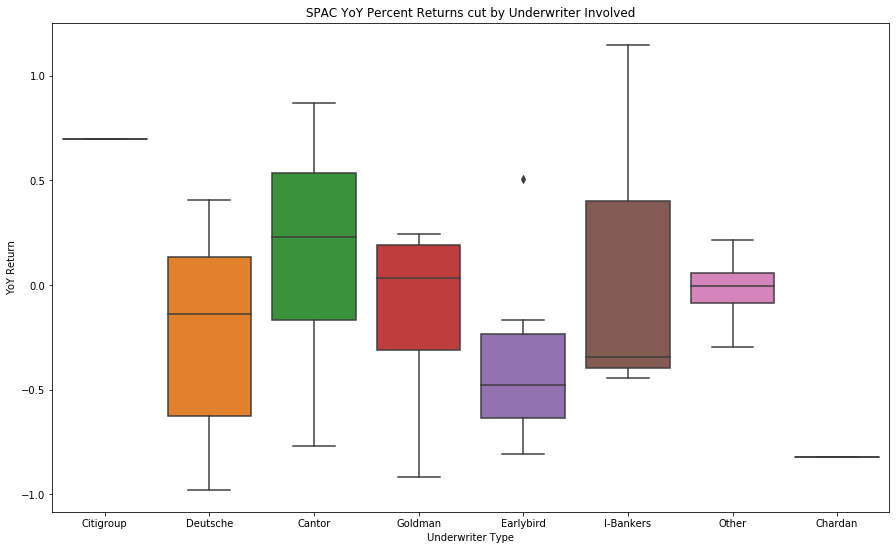

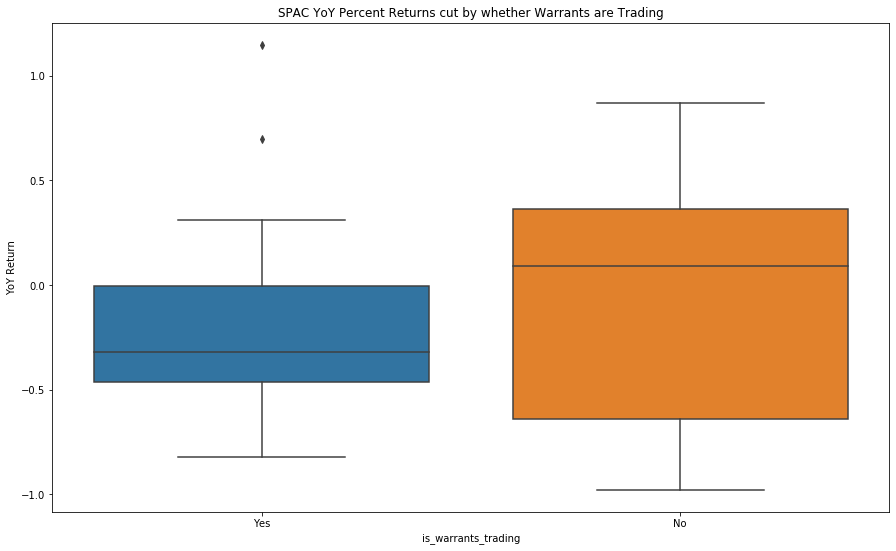

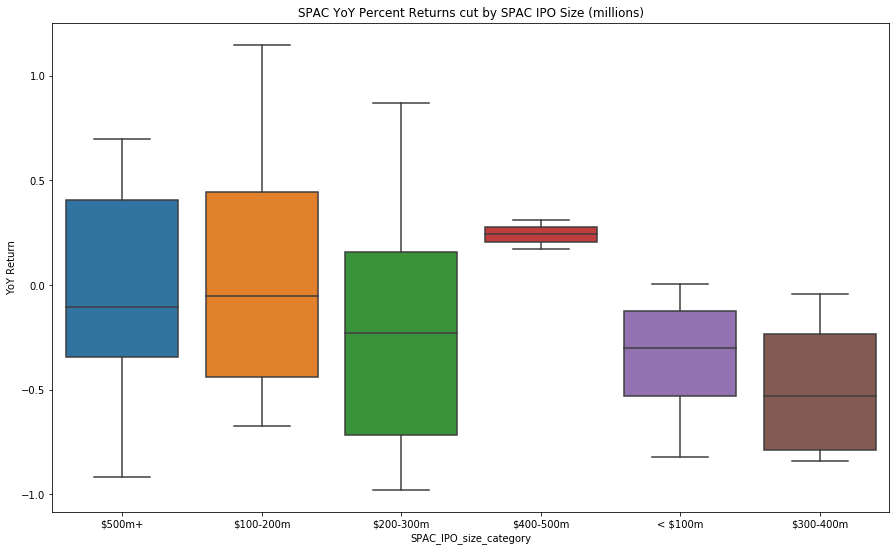

In [9]:
#Remove companies that haven't traded for a year
df_year_plus_spacs = df_spactrack[pd.isnull(df_spactrack['close_1yr_after_completion_date']) == False]

#What are YoY SPAC returns cut by underwriter - we'll rename columns so it looks prettier
df_year_plus_spacs.rename(columns={'underwriter_type_lv':'Underwriter Type',
                             'YoY_return_lv':'YoY Return'}, inplace = True)
plt.figure(figsize = (15,9));
display(sns.boxplot(x = 'Underwriter Type',y='YoY Return',data=df_year_plus_spacs).\
                   set_title('SPAC YoY Percent Returns cut by Underwriter Involved'))

#What are YoY SPAC returns cut by whether warrants are trading?
#Going to have this in a seperate cell so I can edit it further
plt.figure(figsize = (15,9));
display(sns.boxplot(x = 'is_warrants_trading',y='YoY Return',data=df_year_plus_spacs).\
                   set_title('SPAC YoY Percent Returns cut by whether Warrants are Trading'))

#What are YoY SPAC returns cut by SPAC IPO size
plt.figure(figsize = (15,9));
display(sns.boxplot(x = 'SPAC_IPO_size_category',y='YoY Return',data=df_year_plus_spacs).\
                   set_title('SPAC YoY Percent Returns cut by SPAC IPO Size (millions)'))


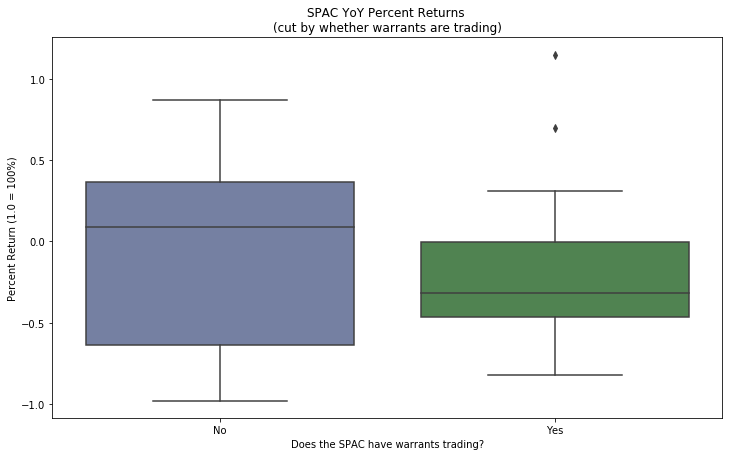

In [10]:
#What are YoY SPAC returns cut by whether warrants are trading?

plt.figure(figsize = (12,7));
g = sns.boxplot(x = 'is_warrants_trading',y='YoY Return'
                    ,data=df_year_plus_spacs, palette = ['#6e7ca9','#488B49'],
                order = ['No', 'Yes'])
g.set_ylabel('Percent Return (1.0 = 100%)');
g.set_xlabel('Does the SPAC have warrants trading?');
g.set_title('SPAC YoY Percent Returns \n(cut by whether warrants are trading)');

Here we look at only companies that have traded less than a year

/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


Text(0.5, 1.0, 'SPAC Percent Returns cut by Underwriter Involved \n (Traded less than a year)')

/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


Text(0.5, 1.0, 'SPAC Percent Returns cut by whether Warrants are Trading \n (Traded less than a year)')

/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


Text(0.5, 1.0, 'SPAC Percent Returns cut by SPAC IPO Size (millions) \n (Traded less than a year)')

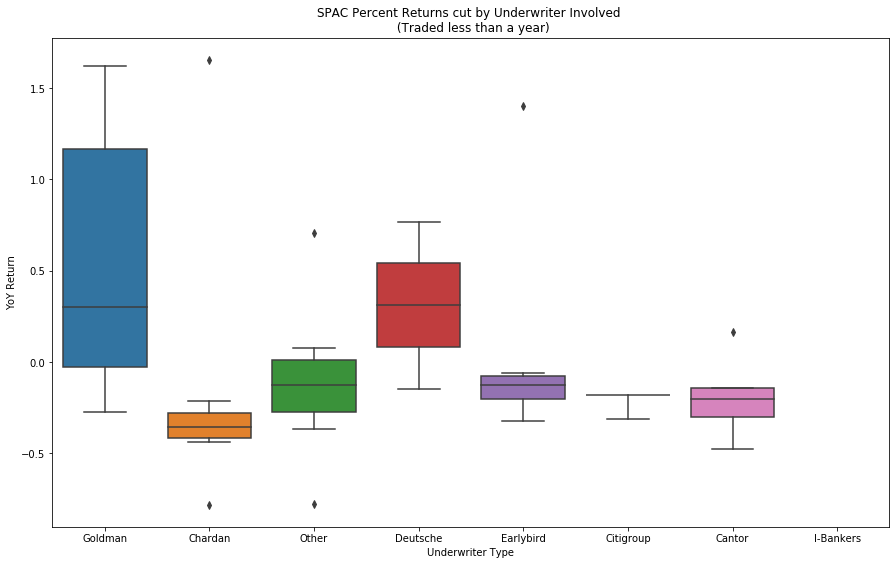

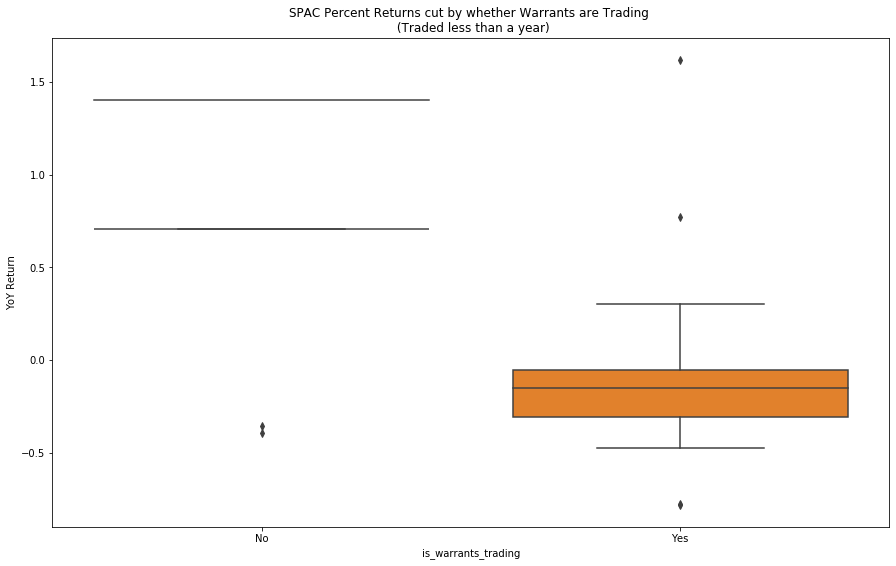

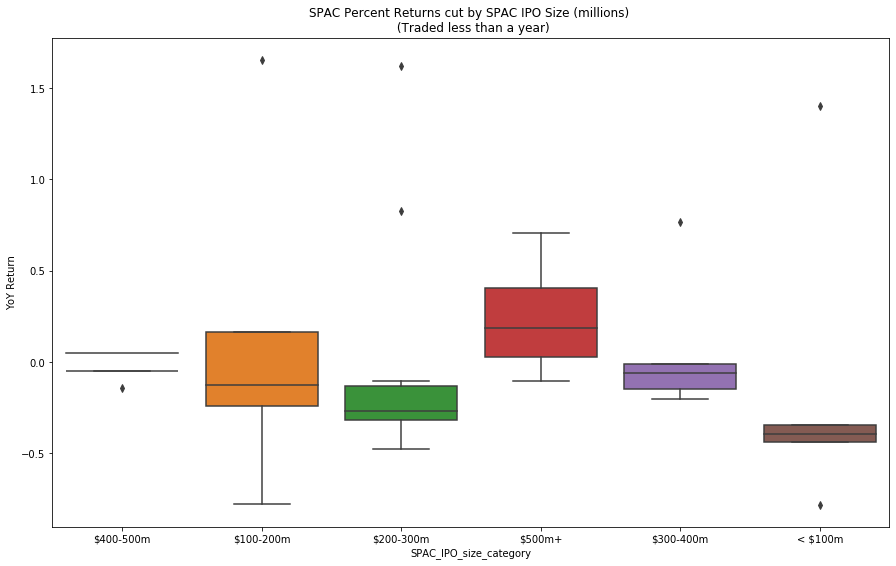

In [11]:
#Remove companies that have traded for more than a year
df_less_than_year_spacs = df_spactrack[pd.isnull(df_spactrack['close_1yr_after_completion_date']) == True]

#What are YoY SPAC returns cut by underwriter - we'll rename columns so it looks prettier
df_less_than_year_spacs.rename(columns={'underwriter_type_lv':'Underwriter Type',
                             'YoY_return_lv':'YoY Return'}, inplace = True)
plt.figure(figsize = (15,9));
display(sns.boxplot(x = 'Underwriter Type',y='YoY Return',data=df_less_than_year_spacs).\
                   set_title('SPAC Percent Returns cut by Underwriter Involved \n (Traded less than a year)'))

#What are YoY SPAC returns cut by whether warrants are trading?
plt.figure(figsize = (15,9));
display(sns.boxplot(x = 'is_warrants_trading',y='YoY Return',data=df_less_than_year_spacs).\
                   set_title('SPAC Percent Returns cut by whether Warrants are Trading \n (Traded less than a year)'))

#What are YoY SPAC returns cut by SPAC IPO size
#Going to include this graph in seperate cell below for formatting
plt.figure(figsize = (15,9));
display(sns.boxplot(x = 'SPAC_IPO_size_category',y='YoY Return',data=df_less_than_year_spacs).\
                   set_title('SPAC Percent Returns cut by SPAC IPO Size (millions) \n (Traded less than a year)'))

/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Users/adrianlechter/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


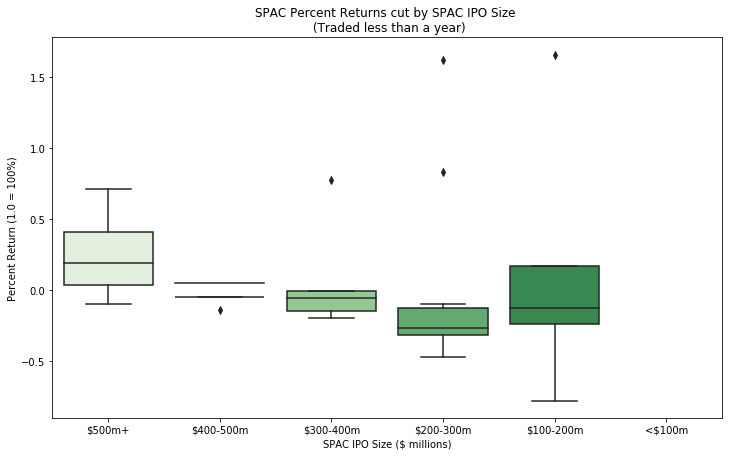

In [12]:
#What are YoY SPAC returns cut by SPAC IPO size
#Going to include this graph in seperate cell below for formatting
plt.figure(figsize = (12,7));
g = sns.boxplot(x = 'SPAC_IPO_size_category',y='YoY Return',data=df_less_than_year_spacs,
                palette = 'Greens',
               order = ['$500m+','$400-500m','$300-400m','$200-300m','$100-200m',
                       '<$100m'])
g.set_title('SPAC Percent Returns cut by SPAC IPO Size \n (Traded less than a year)');
g.set_xlabel('SPAC IPO Size ($ millions)');
g.set_ylabel('Percent Return (1.0 = 100%)');

Here I bucket everything together

Text(0.5, 1.0, 'SPAC YoY Percent Returns cut by Underwriter Involved \n (total returns noted for SPACs trading less than a year)')

Text(0.5, 1.0, 'SPAC YoY Percent Returns cut by whether Warrants are Trading  \n (total returns noted for SPACs trading less than a year')

Text(0.5, 1.0, 'SPAC YoY Percent Returns cut by SPAC IPO Size (millions)  \n (total returns noted for SPACs trading less than a year)')

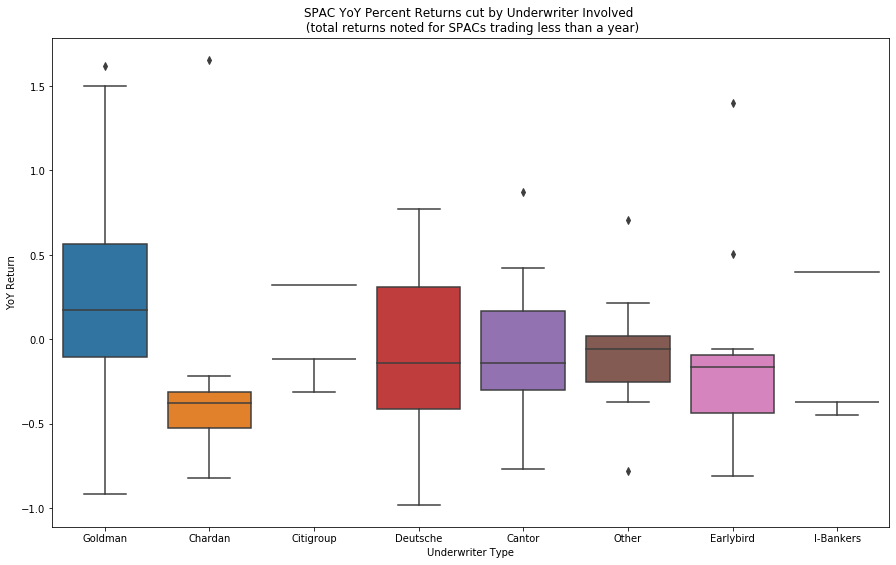

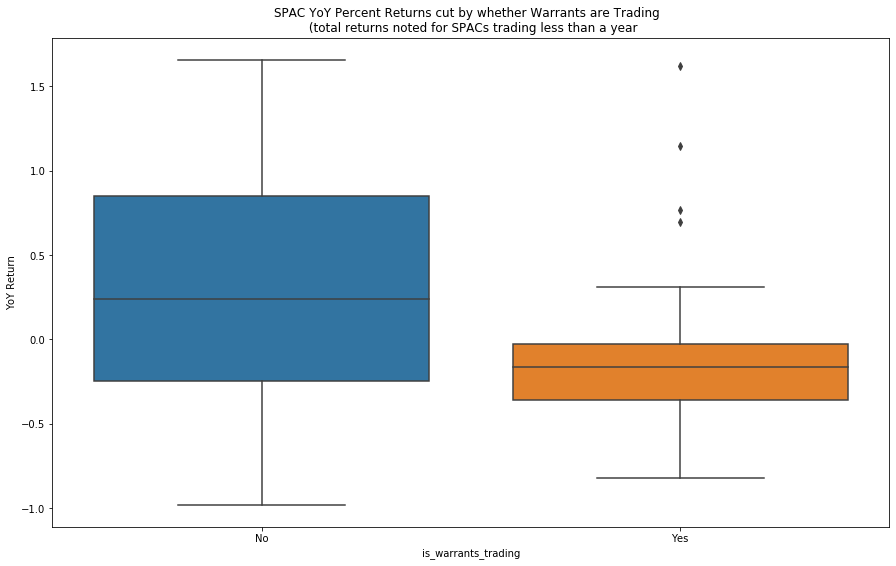

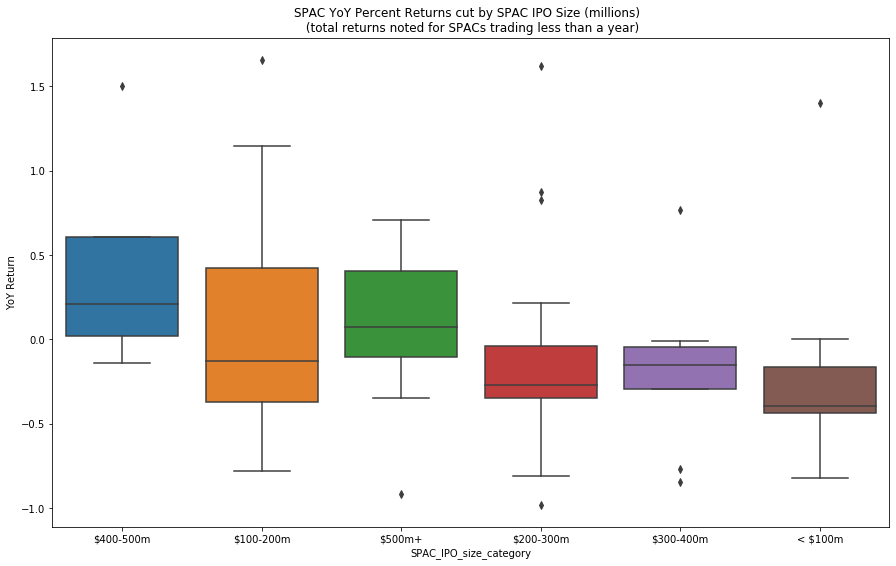

In [13]:
#Include all companies
df_all_spacs = df_spactrack

#What are YoY SPAC returns cut by underwriter - we'll rename columns so it looks prettier
df_all_spacs.rename(columns={'underwriter_type_lv':'Underwriter Type',
                             'YoY_return_lv':'YoY Return'}, inplace = True)
plt.figure(figsize = (15,9));
display(sns.boxplot(x = 'Underwriter Type',y='YoY Return',data=df_all_spacs).\
                   set_title('SPAC YoY Percent Returns cut by Underwriter Involved \n (total returns noted for SPACs trading less than a year)'))

#What are YoY SPAC returns cut by whether warrants are trading?
plt.figure(figsize = (15,9));
display(sns.boxplot(x = 'is_warrants_trading',y='YoY Return',data=df_all_spacs).\
                   set_title('SPAC YoY Percent Returns cut by whether Warrants are Trading  \n (total returns noted for SPACs trading less than a year'))

#What are YoY SPAC returns cut by SPAC IPO size
plt.figure(figsize = (15,9));
display(sns.boxplot(x = 'SPAC_IPO_size_category',y='YoY Return',data=df_all_spacs).\
                   set_title('SPAC YoY Percent Returns cut by SPAC IPO Size (millions)  \n (total returns noted for SPACs trading less than a year)'))

### Appendix

First 2 cells were used to prepare the `open_after_completion_date` loop

In [14]:
if run_appendix:
    completion_date_string = '2020-04-23'
    completion_date_as_date = datetime.strptime(completion_date_string,'%Y-%m-%d')
    day_after_completion_date = completion_date_as_date + timedelta(days = 1)
    display(day_after_completion_date)
    display(day_after_completion_date.weekday())
    
else:
    pass

In [15]:
if run_appendix:
    completion_date = '2019-10-25'
    ticker = 'IPOA'
    day_after_completion_date = datetime.strptime(completion_date,'%Y-%m-%d') +\
                                                                    timedelta(days = 1)

    if day_after_completion_date.weekday() == 5:
        day_after_completion_date += timedelta(days = 2)

    elif day_after_completion_date.weekday() == 6:
        day_after_completion_date += timedelta(days = 1)

    day_after_completion_date = day_after_completion_date.strftime('%Y-%m-%d')


    url =\
    'https://financialmodelingprep.com/api/v3/historical-price-full/{}?from={}&to={}&apikey=fea2346da5cfa1d8bc886e40496d718b'.\
    format(ticker,day_after_completion_date,day_after_completion_date)


#     try:
    url_1 = urllib.request.urlopen(url)
    data = json.loads(url_1.read().decode())
    data

#     except:
#         if not url_1:
#             try:
#                 time.sleep(2) #wait for another try
#                 url_2 = urllib.request.urlopen(url)
#                 data = json.loads(url_2.read().decode())[0]

#             except:
#                 display('you got to this part of script')
#         else:
#             display('End of script error')

#     df_historicals = pd.DataFrame(data) #financial ratios

#     #Preview dataframe before performing cleanup
#     display(df_historicals.head())
#     display(df_historicals.info())
#     display(df_historicals['open'][0])


# else:
#     pass

In [16]:
#Checking to see different ticker/company names
if run_appendix:
    for i in range(len(df_spactrack)):
        display('Ticker is {}, company name is {}'.format(df_spactrack.at[i,'ticker'],
                                                          df_spactrack.at[i,'company_name']))
        
else:
    pass